# Final Modeling notebook

This notebook contains the final models and predictions for COVID19 mortality based upon predictions from the CNN model as a feature, as well as other patient data. This combined data will be used with the best performing model on the patient data to generate predictions for COVID19 mortality outcomes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, re
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score 
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier



In [2]:
df = pd.read_csv('df.csv')
df.head()

,patient_id,last.status,is_icu,length_of_stay,days_prior_sx,8331-1_Oral temperature,59408-5_Oxygen saturation in Arterial blood by Pulse oximetry,9279-1_Respiratory rate,76282-3_Heart rate.beat-to-beat by EKG,8480-6_Systolic blood pressure,...,x7_False,x7_True,x8_False,x8_True,x9_False,x9_True,x10_False,x10_True,x11_False,x11_True
0,A917122,discharged,0.0,9.0,10.6,36.4,91.0,22.0,86.0,172.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,A387558,deceased,1.0,15.0,4.2,37.0,100.0,39.0,149.0,158.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
2,A968238,deceased,1.0,28.0,4.0,37.4,84.0,42.0,88.0,130.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,A106133,deceased,0.0,4.0,6.0,36.7,96.0,16.0,100.0,132.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,A300871,deceased,0.0,3.0,6.0,36.7,97.0,20.0,94.0,104.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [3]:
df.shape

(1313, 58)

In [4]:
pred_df = pd.read_csv('pred_df.csv')
pred_df.head(-10)

,patient_id,prediction
0,deceased\A003797-211.png,[0.5067868232727051]
1,deceased\A003797-213.png,[0.45103394985198975]
2,deceased\A003797-215.png,[0.5482220649719238]
3,deceased\A003797-217.png,[0.43986982107162476]
4,deceased\A003797-219.png,[0.46855348348617554]
...,...,...
6685,discharged\A993649-13609.png,[0.5549108982086182]
6686,discharged\A993649-13611.png,[0.595093309879303]
6687,discharged\A993649-13613.png,[0.553656816482544]
6688,discharged\A993649-13615.png,[0.47506052255630493]


In [5]:
pred_df.shape

(6700, 2)

In [6]:
# pred_df['patient_id'].apply(re.findall(r'A[0-9]{6}', pred_df['patient_id']))

In [7]:
type(pred_df['patient_id'][0])

str

In [8]:
pred_df['new_id'] = pred_df['patient_id'].str.extract(r'(A[0-9]{6})')

In [9]:
pred_df.head()

,patient_id,prediction,new_id
0,deceased\A003797-211.png,[0.5067868232727051],A003797
1,deceased\A003797-213.png,[0.45103394985198975],A003797
2,deceased\A003797-215.png,[0.5482220649719238],A003797
3,deceased\A003797-217.png,[0.43986982107162476],A003797
4,deceased\A003797-219.png,[0.46855348348617554],A003797


In [10]:
pred_df['prediction'] = pred_df['prediction'].str.strip('[]')

In [11]:
#convert predictions to float

pred_df['prediction'] = pred_df['prediction'].astype(float)

In [12]:
pred_df.dtypes

patient_id     object
prediction    float64
new_id         object
dtype: object

In [13]:
pred_df.head()

,patient_id,prediction,new_id
0,deceased\A003797-211.png,0.506787,A003797
1,deceased\A003797-213.png,0.451034,A003797
2,deceased\A003797-215.png,0.548222,A003797
3,deceased\A003797-217.png,0.439870,A003797
4,deceased\A003797-219.png,0.468553,A003797


In [14]:
#obtain mean prediction values for each patient

predmeans_df = pred_df.groupby('new_id', as_index=False)['prediction'].mean()
predmeans_df.head()

,new_id,prediction
0,A000801,0.619411
1,A000936,0.688039
2,A001375,0.791101
3,A001942,0.815414
4,A002052,0.624444


In [15]:
#shape predmeans_df
predmeans_df.shape

(1332, 2)

In [16]:
predmeans_df.rename({'new_id':'patient_id'}, axis=1, inplace=True)

In [17]:
predmeans_df.head()

,patient_id,prediction
0,A000801,0.619411
1,A000936,0.688039
2,A001375,0.791101
3,A001942,0.815414
4,A002052,0.624444


#### Insight: some patient IDs were lost. These patient rows will have to be dropped from the final df

In [18]:
#merge predmeans_df with df

final_df = df.merge(predmeans_df, on='patient_id', how='outer')
final_df.head()

,patient_id,last.status,is_icu,length_of_stay,days_prior_sx,8331-1_Oral temperature,59408-5_Oxygen saturation in Arterial blood by Pulse oximetry,9279-1_Respiratory rate,76282-3_Heart rate.beat-to-beat by EKG,8480-6_Systolic blood pressure,...,x7_True,x8_False,x8_True,x9_False,x9_True,x10_False,x10_True,x11_False,x11_True,prediction
0,A917122,discharged,0.0,9.0,10.6,36.4,91.0,22.0,86.0,172.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.658740
1,A387558,deceased,1.0,15.0,4.2,37.0,100.0,39.0,149.0,158.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.607654
2,A968238,deceased,1.0,28.0,4.0,37.4,84.0,42.0,88.0,130.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.530055
3,A106133,deceased,0.0,4.0,6.0,36.7,96.0,16.0,100.0,132.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,NaN
4,A300871,deceased,0.0,3.0,6.0,36.7,97.0,20.0,94.0,104.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.290393


In [19]:
#check for null rows
final_df.isna().sum()

patient_id                                                                                                                                    0
last.status                                                                                                                                  70
is_icu                                                                                                                                       70
length_of_stay                                                                                                                               70
days_prior_sx                                                                                                                                70
8331-1_Oral temperature                                                                                                                      70
59408-5_Oxygen saturation in Arterial blood by Pulse oximetry                                                                           

In [20]:
#set patient_id as index

final_df.set_index('patient_id', inplace=True)
final_df.head()

,last.status,is_icu,length_of_stay,days_prior_sx,8331-1_Oral temperature,59408-5_Oxygen saturation in Arterial blood by Pulse oximetry,9279-1_Respiratory rate,76282-3_Heart rate.beat-to-beat by EKG,8480-6_Systolic blood pressure,76536-2_Mean blood pressure by Noninvasive,...,x7_True,x8_False,x8_True,x9_False,x9_True,x10_False,x10_True,x11_False,x11_True,prediction
patient_id,,,,,,,,,,,,,,,,,,,,,
A917122,discharged,0.0,9.0,10.6,36.4,91.0,22.0,86.0,172.0,91.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.658740
A387558,deceased,1.0,15.0,4.2,37.0,100.0,39.0,149.0,158.0,109.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.607654
A968238,deceased,1.0,28.0,4.0,37.4,84.0,42.0,88.0,130.0,93.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.530055
A106133,deceased,0.0,4.0,6.0,36.7,96.0,16.0,100.0,132.0,71.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,NaN
A300871,deceased,0.0,3.0,6.0,36.7,97.0,20.0,94.0,104.0,99.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.290393


In [21]:
final_df.shape

(1383, 58)

In [22]:
final_df.dropna(axis=0, inplace=True)
final_df.shape

(1262, 58)

In [23]:
#define X and y, remap last.status, perform tts

X = final_df.drop(labels=['last.status'], axis=1)
mapping = {'discharged':1, 'deceased':0}
y = final_df['last.status'].replace(mapping)

In [24]:
X.shape

(1262, 57)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [26]:
#attempt to scale the data w/ standardscaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
X_train_scaled

array([[ 2.24542116,  1.24443237,  0.0237798 , ...,  0.62281254,
        -0.62281254, -1.35677915],
       [-0.44535075, -0.3055183 , -0.53722681, ...,  0.62281254,
        -0.62281254, -1.27569213],
       [-0.44535075, -0.3055183 ,  0.06693416, ..., -1.60561956,
         1.60561956, -1.32757289],
       ...,
       [-0.44535075,  0.03891518,  1.53418223, ...,  0.62281254,
        -0.62281254, -0.76437799],
       [-0.44535075,  0.46945703,  0.67109513, ...,  0.62281254,
        -0.62281254, -0.0339591 ],
       [-0.44535075, -0.39162667, -1.27085085, ...,  0.62281254,
        -0.62281254, -0.28164924]])

### Dummy classifier baseline model

In [28]:
#creation of baseline model with dummy classifier



dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_scaled, y_train)
dummy.score(X_test_scaled, y_test)

0.8932806324110671

### Functions for plots and metrics

In [29]:
def metrics_crossval_score(model, X_train, X_test, y_train, y_test, y_pred):
    train = cross_val_score(model, X_train, y_train, cv=5).mean()
    test = cross_val_score(model, X_test, y_test, cv=5).mean()
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    return ("Training set score:", train), ("Test set score:", test), ('Accuracy:', acc), ('F1 score:', f1), ('Precision:', prec)



In [30]:
def plot_matrix(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    
    return sns.heatmap(matrix, annot=True, cmap='BuPu', fmt='.4g', xticklabels=['Deceased', 'Discharged'], 
                       yticklabels=['Deceased', 'Discharged']), plt.yticks(rotation=0)

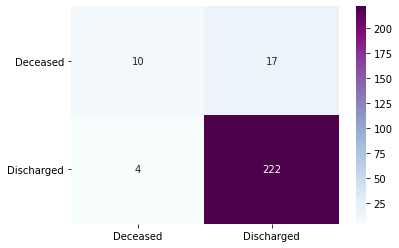

In [32]:
knn = KNeighborsClassifier(n_neighbors=13, metric='euclidean')

knn.fit(X_train_scaled, y_train)
knn_pred = knn.predict(X_test_scaled)
plot_matrix(y_test, knn_pred);

In [33]:
metrics_crossval_score(knn, X_train_scaled, X_test_scaled, y_train, y_test, knn_pred)

(('Training set score:', 0.9187281414708636),
 ('Test set score:', 0.9011764705882352),
 ('Accuracy:', 0.9169960474308301),
 ('F1 score:', 0.9548387096774195),
 ('Precision:', 0.9288702928870293))

In [34]:


knn_params = {'n_neighbors': list(range(1, 29, 2)),
       'metric': ['euclidean', 'manhattan', 'minkowski']}

knn_grid = GridSearchCV(estimator=knn, param_grid=knn_params)
knn_grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=KNeighborsClassifier(metric='euclidean', n_neighbors=13),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27]})

In [35]:
knn_grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 5}

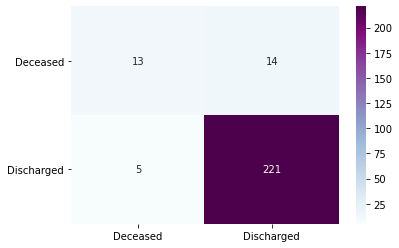

In [36]:
knn2 = KNeighborsClassifier(n_neighbors=5, metric='manhattan')

knn2.fit(X_train_scaled, y_train)
knn_pred2 = knn2.predict(X_test_scaled)
plot_matrix(y_test, knn_pred2);

In [37]:
metrics_crossval_score(knn2, X_train_scaled, X_test_scaled, y_train, y_test, knn_pred2)

(('Training set score:', 0.9276587360228559),
 ('Test set score:', 0.9288627450980392),
 ('Accuracy:', 0.924901185770751),
 ('F1 score:', 0.9587852494577007),
 ('Precision:', 0.9404255319148936))